# Estudos de Modelagem Analítica


## Analise exploratória dos dados

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import scipy.special as special 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from sklearn.metrics import mean_absolute_percentage_error
from pandas import concat
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [25]:
#Select a percentage from the time series
def data_proportion(series, percent=1.0, end=True):
    if end: 
        series = series[-int(percent * len(series)):]
    else: 
        series = series[:int(percent * len(series))]
    return series

In [19]:
#load de data
df = pd.read_csv('hourly_20140102_20191101_train.csv', 
                 index_col=['datetime'],
                header=0, parse_dates=['datetime'], usecols=['value','datetime']
                 ,squeeze=True)

In [129]:
df.describe()

count    245376.000000
mean      28505.403230
std        4596.955053
min       17714.000000
25%       24593.000000
50%       28720.000000
75%       31997.000000
max       41217.000000
Name: value, dtype: float64

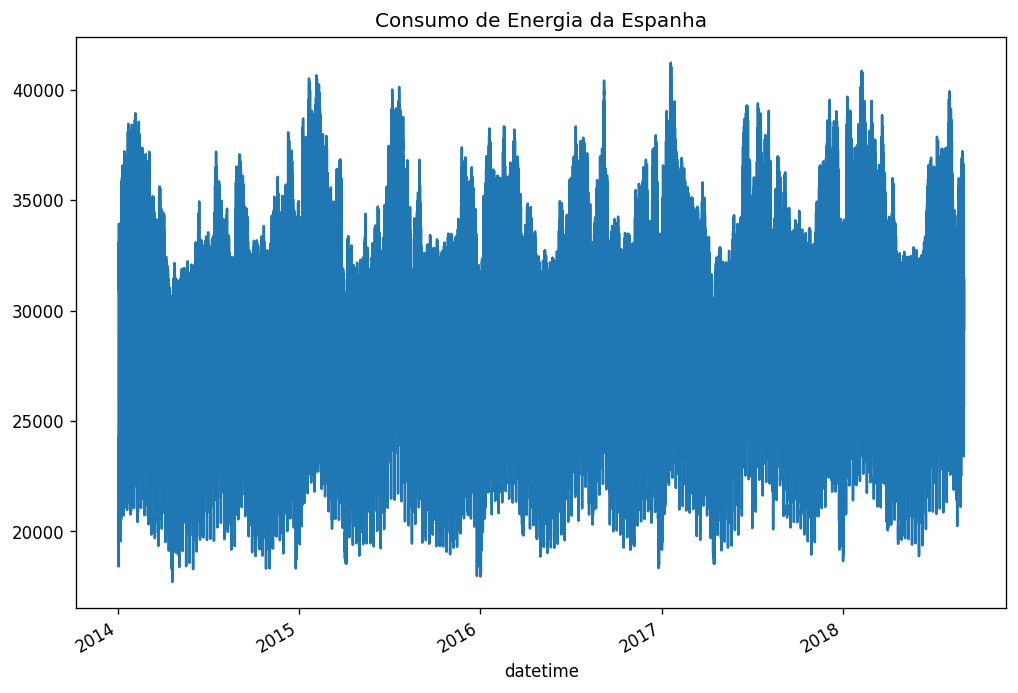

In [22]:
df.plot()
plt.title("Consumo de Energia da Espanha")
plt.show()

## Analise diária

In [169]:
df = pd.read_csv('hourly_20140102_20191101_train.csv', 
                 index_col=['datetime'],
                header=0, parse_dates=['datetime'], usecols=['value','datetime'])

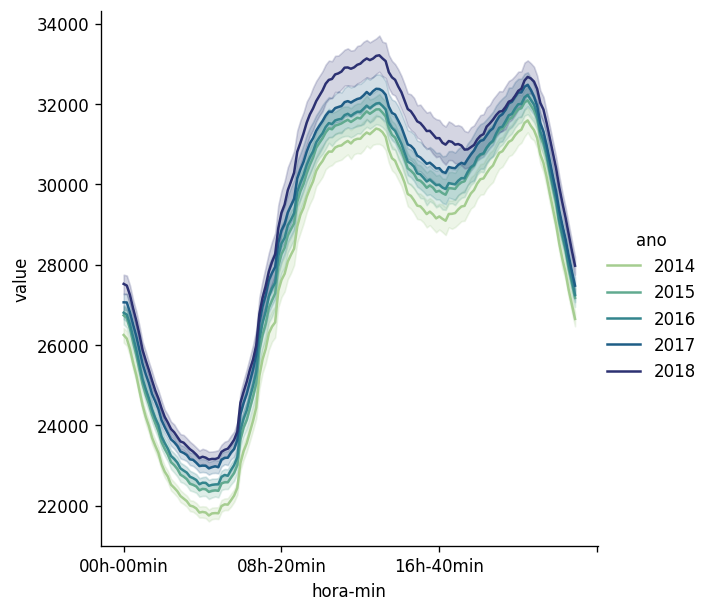

In [171]:
df['ano'] = [d.year for d in df.index]
df['hora-min'] = [d.strftime('%Hh-%Mmin') for d in df.index]
ax = sns.relplot(data=df, x="hora-min", y="value", hue="ano", kind="line", palette="crest");

# format the labels with f-strings
for t in ax.axes.flat:
    t.xaxis.set_major_locator(ticker.MultipleLocator(50))

## Analise Semanal

In [172]:
df['d-semana'] = [d.strftime('%A') for d in df.index]

/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


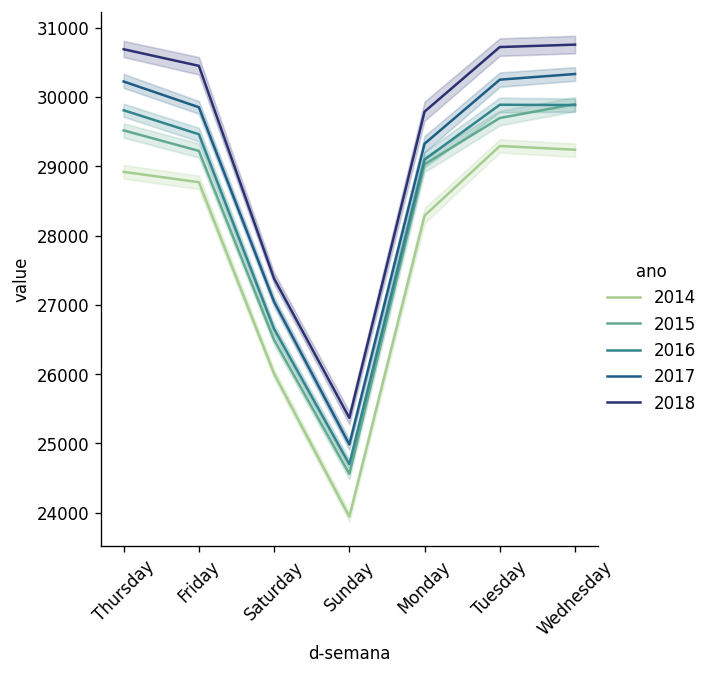

In [180]:
d = sns.relplot(data=df, x="d-semana", y="value", hue="ano", kind="line", palette="crest")
for t in d.axes.flat:
    t.set_xticklabels(t.get_xticklabels(),rotation=45)

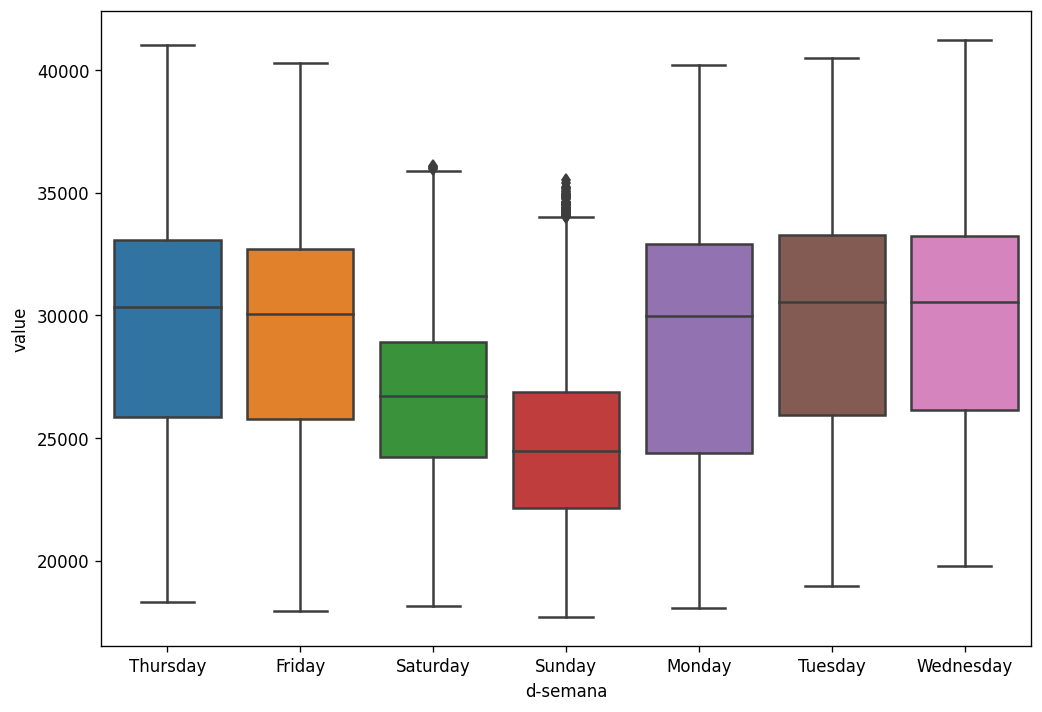

In [176]:
df['d-semana'] = [d.strftime('%A') for d in df.index]

d = sns.boxplot(x='d-semana', y='value', data=df)

plt.show()

## Analise Mensal

In [181]:
df['mes'] = [d.strftime('%b') for d in df.index]

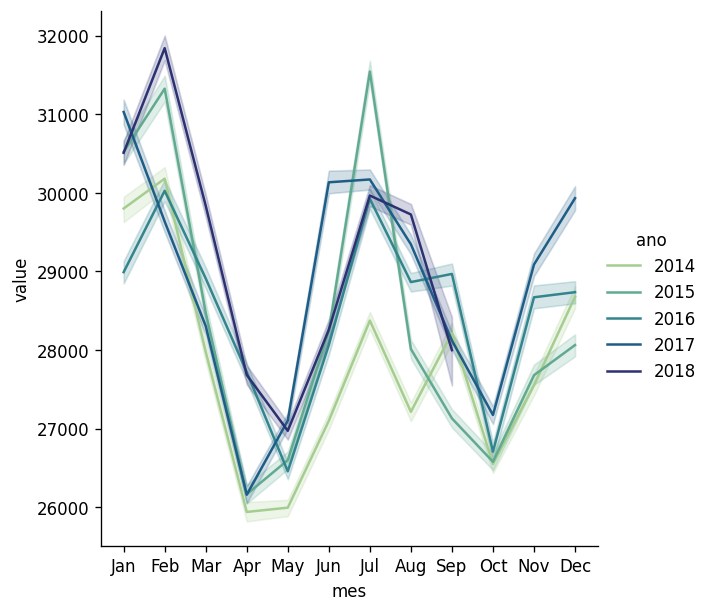

In [182]:
sns.relplot(data=df, x="mes", y="value", hue="ano", kind="line", palette="crest");

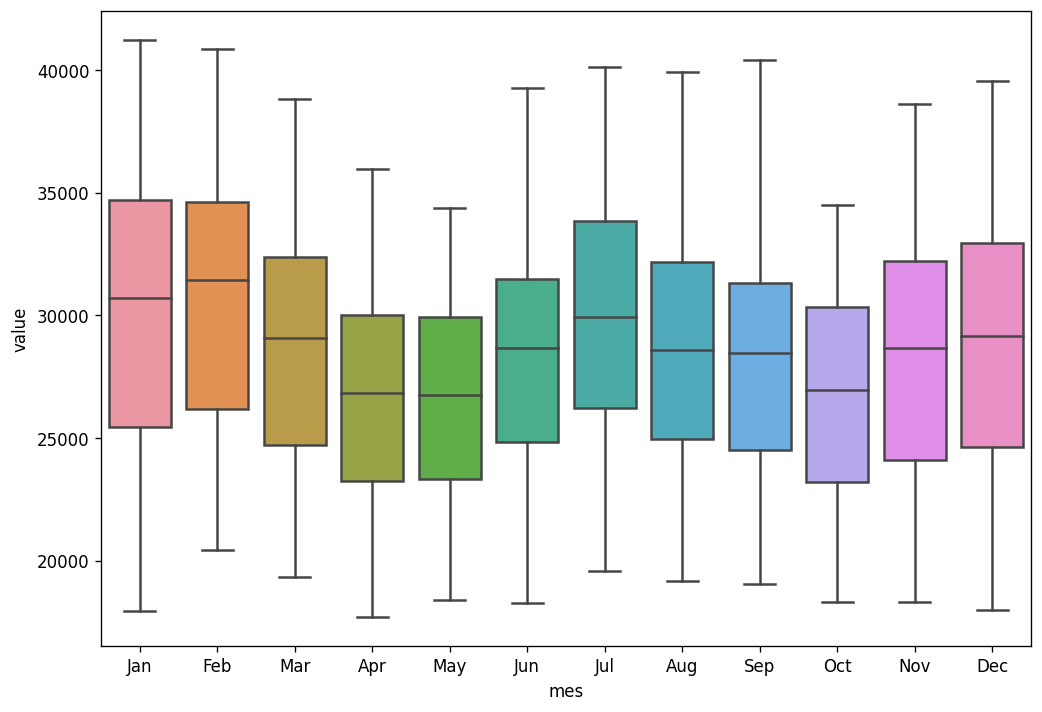

In [184]:
sns.boxplot(x='mes', y="value", data=df)
plt.show()

## Analise Anual

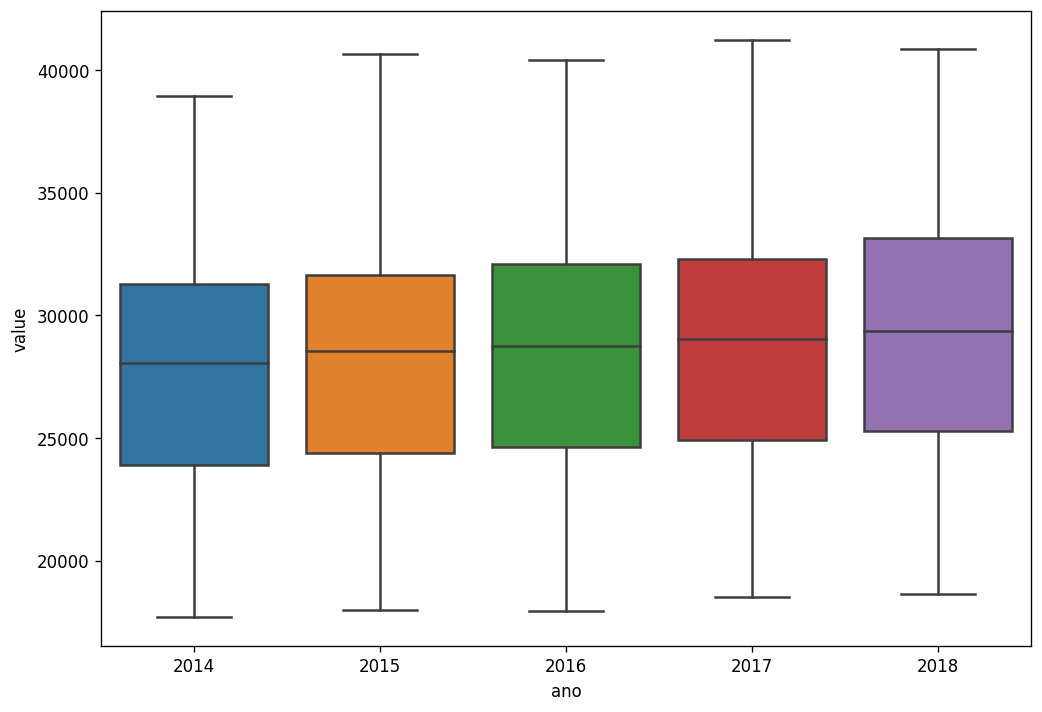

In [185]:
sns.boxplot(x='ano', y="value", data=df)
plt.show()

## Decomposição da Série

In [46]:
df = pd.read_csv('hourly_20140102_20191101_train.csv', 
                 index_col=['datetime'],
                header=0, parse_dates=['datetime'], usecols=['value','datetime']
                 ,squeeze=True)

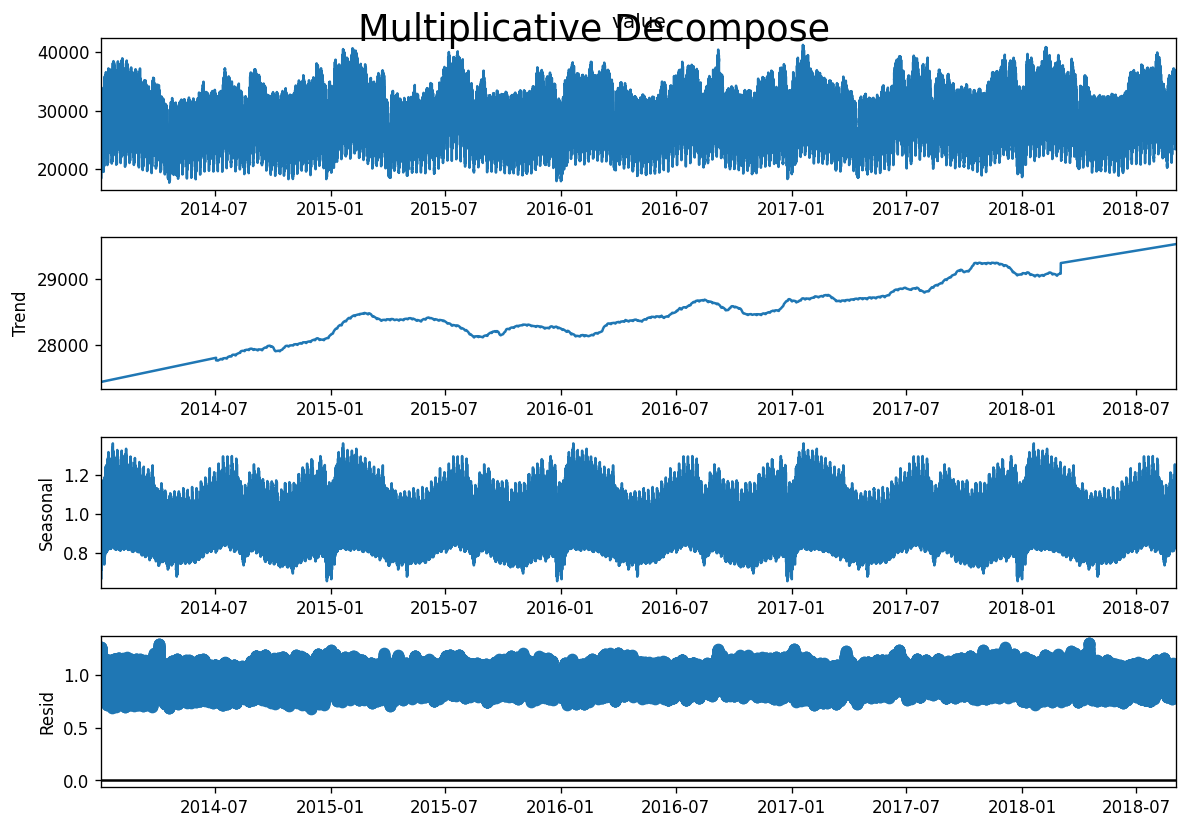

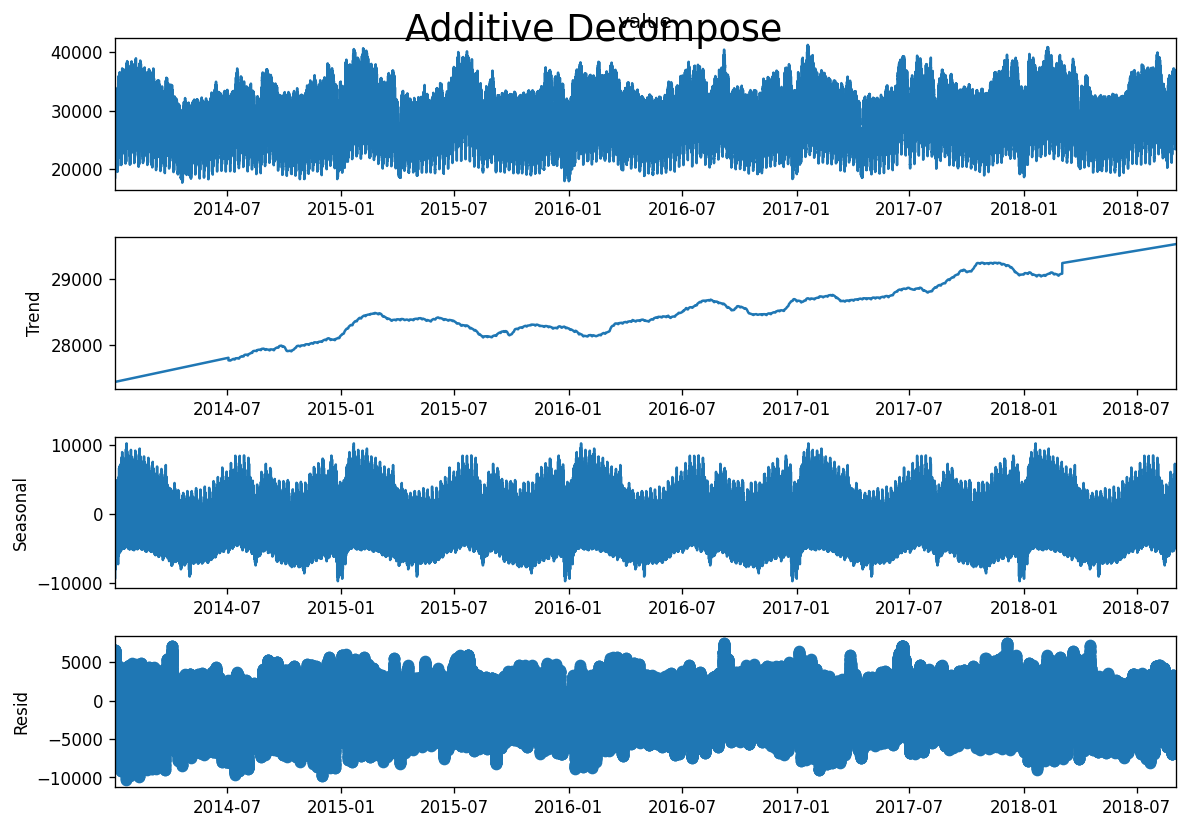

In [50]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model='multiplicative', period=365*24*6, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df, model='additive',period=365*24*6, extrapolate_trend='freq')

# Plot
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [51]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed_mul = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed_mul.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_mul.to_csv('timeserie_decom_mul_train.csv')
#df_reconstructed_mul.head()


In [52]:
# Actual Values = Sum of (Seasonal * Trend * Resid)
df_reconstructed_add = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed_add.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_add.to_csv('timeserie_decom_add_train.csv')
#df_reconstructed_add.head()

## Transformadas e Histogramas

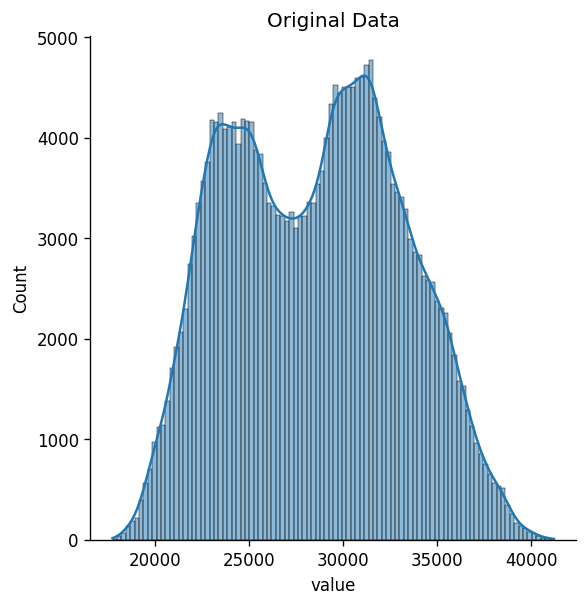

In [53]:
sns.displot(df, kde=True)
plt.title("Original Data")
plt.show()

### Transformada Ln

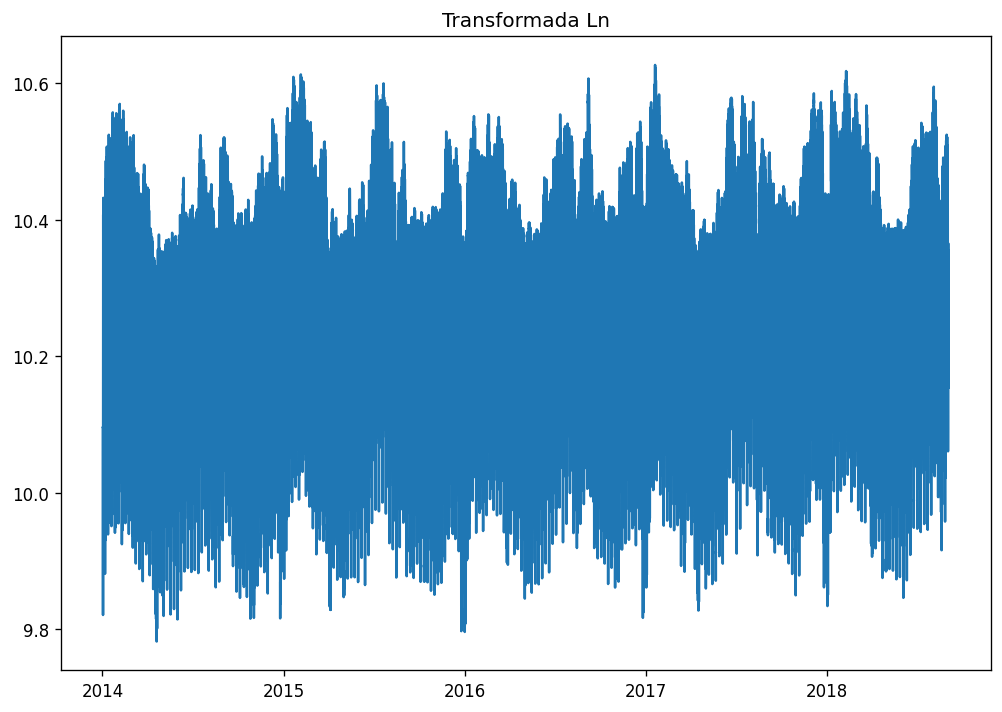

In [55]:
ts_log = np.log(df)
plt.title("Transformada Ln")
plt.plot(ts_log)
ts_log.to_csv('timeserie_log_train.csv')

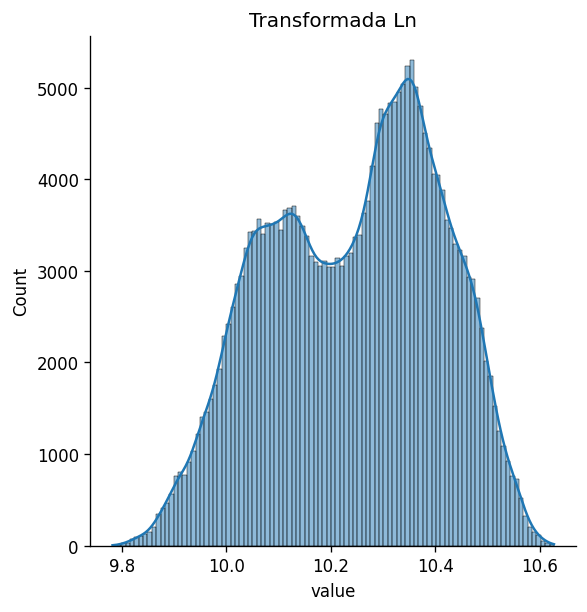

In [56]:
sns.displot(ts_log, kde=True)
plt.title("Transformada Ln")
plt.show()

### Transformada Box Cox

In [57]:
def boxcox_series(timeserie):
    fitted_data, fitted_lambda = stats.boxcox(timeserie) 
    box_cox = pd.concat([pd.DataFrame(timeserie.index),pd.DataFrame(fitted_data)],ignore_index=True,axis=1)
    box_cox.rename(columns = {0:'data' ,1:'energia'}, inplace = True)
    box_cox["lambda"] = fitted_lambda
    box_cox.reset_index(drop=True, inplace=True)
    box_cox = box_cox.set_index('data')
    return box_cox

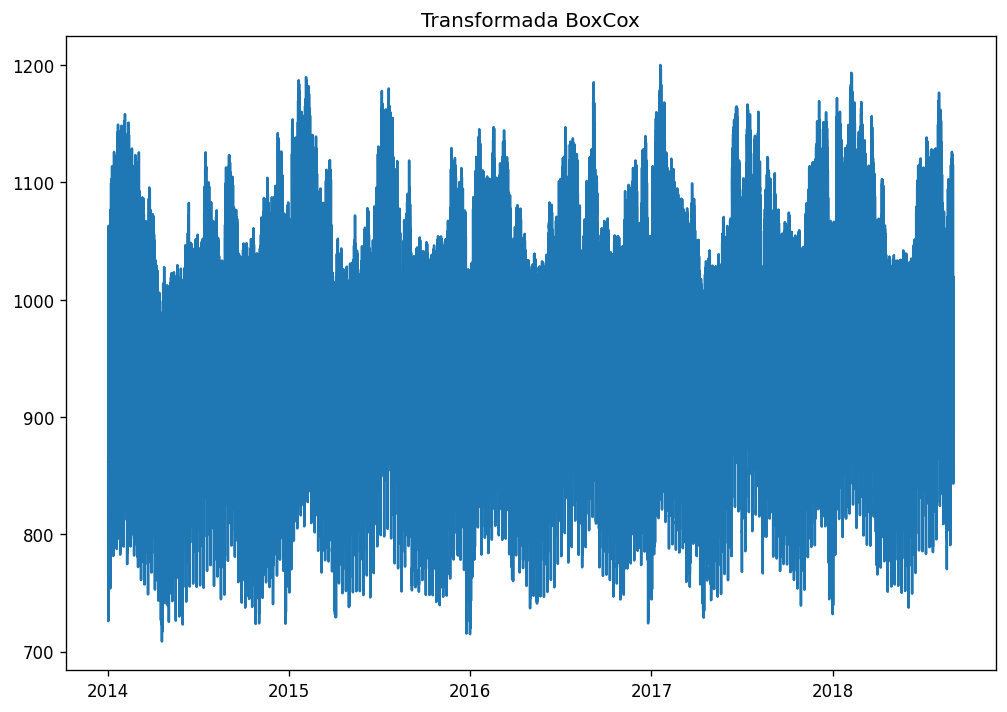

In [60]:
ts_box_cox = boxcox_series(df)
plt.title("Transformada BoxCox")
plt.plot(ts_box_cox.energia)

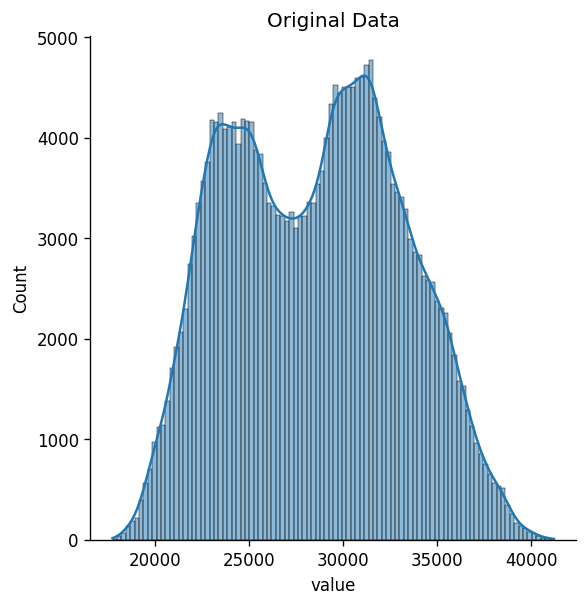

In [61]:
sns.displot(df, kde=True)
plt.title("Original Data")
plt.show()

## Média Movel

In [64]:
def rolling_mean(timeseries, title=""):
    #Determing rolling statistics
    rolmean = timeseries.rolling(365*24*6).mean()
    rolstd = timeseries.rolling(365*24*6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    if title:
        plt.title('Rolling Mean & Standard Deviation: ' + title)
    else:
        plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


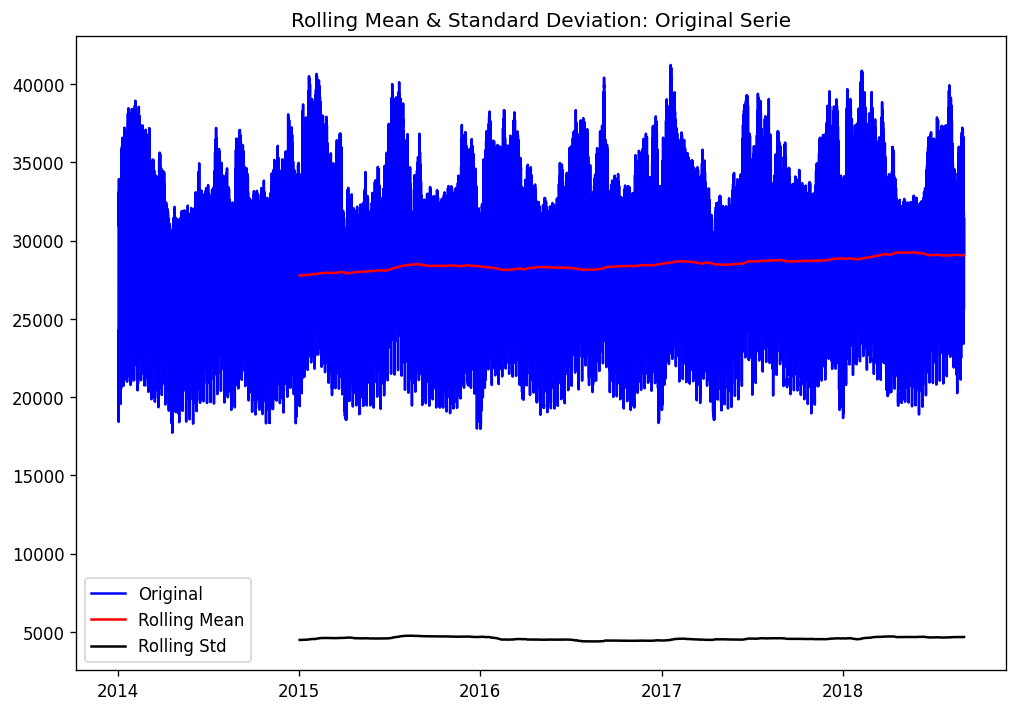

In [65]:
rolling_mean(df, "Original Serie")

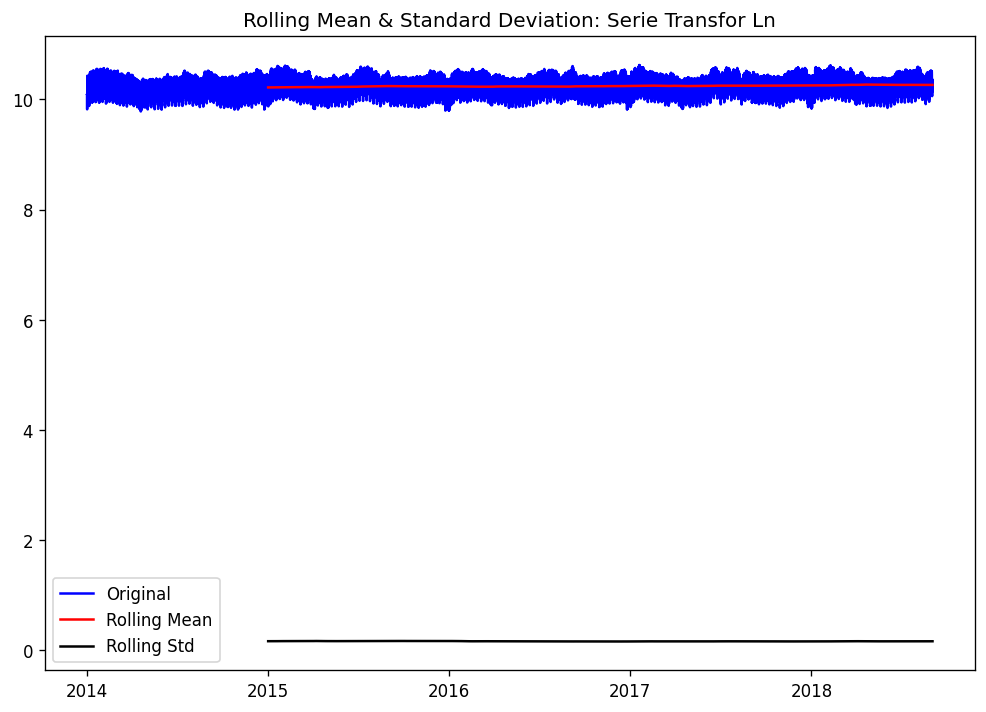

In [66]:
rolling_mean(ts_log, "Serie Transfor Ln")

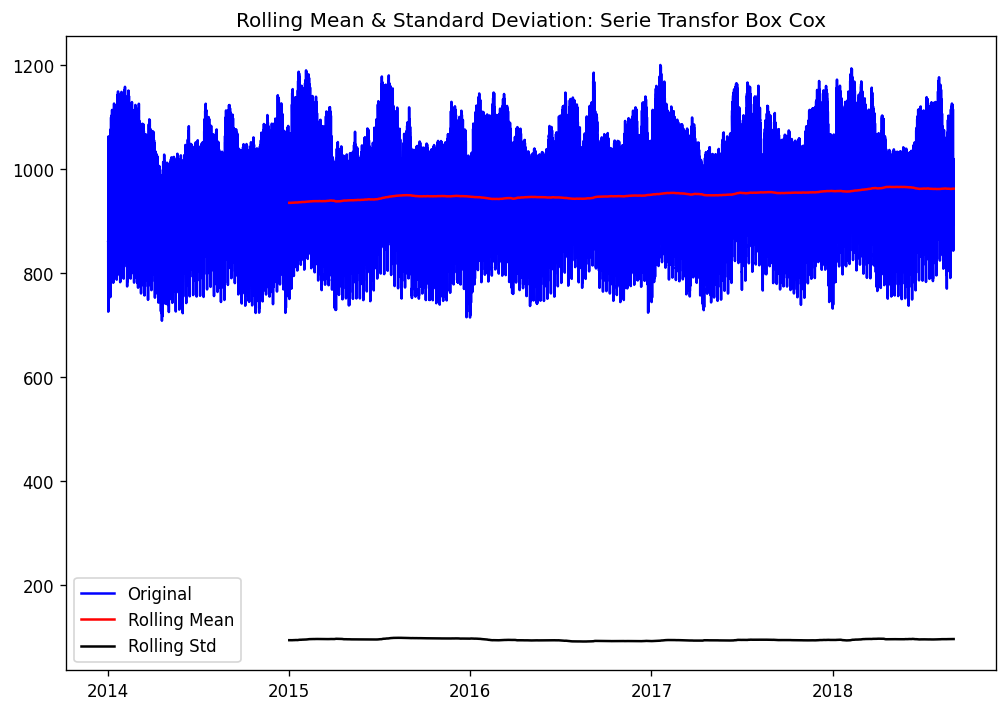

In [67]:
rolling_mean(ts_box_cox.energia, "Serie Transfor Box Cox")

## Testes de Estacionariedade

In [68]:
def ADF_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

In [69]:
def KPSS(timeseries):
    print('\nResults of KPSS Test:')
    result = kpss(timeseries, regression='c')
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

### Dados Originais

In [70]:
ADF_test(df)

Results of Dickey-Fuller Test:
ADF Statistic: -33.09753686798537
p-value: 0.0
Critial Values:
   1%, -3.430376659743302
Critial Values:
   5%, -2.861551783265775
Critial Values:
   10%, -2.5667762718066442


In [71]:
KPSS(df)


Results of KPSS Test:
KPSS Statistic: 4.898252
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [72]:
pp = PhillipsPerron(df)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -37.978
P-value                         0.000
Lags                               85
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Transformada Ln

In [73]:
ADF_test(ts_log)

Results of Dickey-Fuller Test:
ADF Statistic: -33.06498358149904
p-value: 0.0
Critial Values:
   1%, -3.430376659743302
Critial Values:
   5%, -2.861551783265775
Critial Values:
   10%, -2.5667762718066442


In [74]:
KPSS(ts_log)


Results of KPSS Test:
KPSS Statistic: 4.998266
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [75]:
pp = PhillipsPerron(ts_log)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -38.158
P-value                         0.000
Lags                               85
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Transformada Box-Cox 

In [76]:
ADF_test(ts_box_cox.energia)

Results of Dickey-Fuller Test:
ADF Statistic: -33.03986223159897
p-value: 0.0
Critial Values:
   1%, -3.430376659743302
Critial Values:
   5%, -2.861551783265775
Critial Values:
   10%, -2.5667762718066442


In [77]:
KPSS(ts_box_cox.energia)


Results of KPSS Test:
KPSS Statistic: 4.934005
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/nivaldogomes-labcodes/Documents/Dropbox/My Mac (Home-Nivaldos-MacBook-Pro.local)/Documents/1 - Projetos/modelagem analitica/.env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), Int

In [78]:
pp = PhillipsPerron(ts_box_cox.energia)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -38.050
P-value                         0.000
Lags                               85
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Previsões

In [80]:
train = pd.read_csv('hourly_20140102_20191101_train.csv', 
                 index_col=['datetime'],
                header=0, parse_dates=['datetime'], usecols=['value','datetime']
                 ,squeeze=True)

test = pd.read_csv('hourly_20140102_20191101_test.csv', 
                 index_col=['datetime'],
                header=0, parse_dates=['datetime'], usecols=['value','datetime']
                 ,squeeze=True)

In [105]:
# calcuilate simple error
def error(actual, predicted):
    return actual - predicted

# calculate Mean Absolute Error - MAE
def mae(actual, predicted):
    return np.mean(np.abs(error(actual, predicted)))

# calculate Weighted Absolute Percentage Error - WAPE
def wape(actual, predicted):
    return mae(actual, predicted)/np.mean(actual)

In [111]:
def persistence_one_step(train, test, show_results=False, plot_result=False):
    # Prepare data
    test = test.values
    train = [x for x in train]
    
    # Walk-forward validation
    predictions = list()
    
    for i in range(len(test)):
        # Predict
        yhat = train[-1]
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
        
    # Report performance
    wape_value = wape(test, predictions)
    print('WAPE: %.3f' % wape_value)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.show()


In [112]:
persistence_one_step(train, test)

WAPE: 0.008


### Persistence multi step

In [83]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    plt.plot(series)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]  
        plt.plot(xaxis, yaxis, color='red')
    # Show the final plot
    plt.show()  

In [88]:
def persistence_multi_step(train,test, steps=24, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([train, test], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train = [x for x in train]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train[-1]
        yhat = persistence(last_ob, n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train.append(obs)
    # Evaluate the forecasts
    evaluate_forecasts(test, forecasts, n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts(series, forecasts, test)


In [115]:
# Evaluate the MAPE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print('t+%d WAPE: %f' % ((i+1), (wape(ytrue_ts, ypred_ts))))

In [116]:
# Make a multi-step persistence forecast
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


In [117]:
persistence_multi_step(train, test, plot_result=False)

t+1 WAPE: 0.008149
t+2 WAPE: 0.013647
t+3 WAPE: 0.019447
t+4 WAPE: 0.025350
t+5 WAPE: 0.031154
t+6 WAPE: 0.036977
t+7 WAPE: 0.042753
t+8 WAPE: 0.048420
t+9 WAPE: 0.053950
t+10 WAPE: 0.059410
t+11 WAPE: 0.064756
t+12 WAPE: 0.069975
t+13 WAPE: 0.075115
t+14 WAPE: 0.080125
t+15 WAPE: 0.085023
t+16 WAPE: 0.089830
t+17 WAPE: 0.094517
t+18 WAPE: 0.099082
t+19 WAPE: 0.103547
t+20 WAPE: 0.107899
t+21 WAPE: 0.112127
t+22 WAPE: 0.116241
t+23 WAPE: 0.120236
t+24 WAPE: 0.124091


### Transformada Ln


In [92]:
train_log = np.log(train)

#### Persistence One Step

In [118]:
def persistence_one_step_ln(train_log, teste, 
    show_results=False, plot_result=False):
    # Prepare data
    teste = teste.values
    train_log = [x for x in train_log]

    # Walk-forward validation
    predictions = list()

    for i in range(len(teste)):
        # Predict
        yhat = train_log[-1]
        # Store forecast in list of predictions
        predictions.append(np.exp(yhat))
        # Add actual observation to train for the next loop
        obs = teste[i]
        train_log.append(np.log(obs))
        
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


    # Report performance
    wape_value = wape(teste, predictions)
    print('WAPE: %.3f' % wape_value)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(teste)
        plt.plot(predictions, color='red')
        plt.show()

In [119]:
persistence_one_step_ln(train_log, test)

WAPE: 0.008


In [120]:
def persistence_multi_step_ln(train_log,test, steps=7, plot_result=False):

    # Concatenate train/test series for plotting
    series = concat([np.exp(train_log), test], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train_log = [x for x in train_log]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob =  train_log[-1]
        yhat = persistence(np.exp(last_ob), n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train_log.append(np.log(obs))
    # Evaluate the forecasts
    evaluate_forecasts(test, forecasts, n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts(series, forecasts, test)

In [121]:
persistence_multi_step_ln(train_log, test, steps=24, plot_result=False)

t+1 WAPE: 0.008149
t+2 WAPE: 0.013647
t+3 WAPE: 0.019447
t+4 WAPE: 0.025350
t+5 WAPE: 0.031154
t+6 WAPE: 0.036977
t+7 WAPE: 0.042753
t+8 WAPE: 0.048420
t+9 WAPE: 0.053950
t+10 WAPE: 0.059410
t+11 WAPE: 0.064756
t+12 WAPE: 0.069975
t+13 WAPE: 0.075115
t+14 WAPE: 0.080125
t+15 WAPE: 0.085023
t+16 WAPE: 0.089830
t+17 WAPE: 0.094517
t+18 WAPE: 0.099082
t+19 WAPE: 0.103547
t+20 WAPE: 0.107899
t+21 WAPE: 0.112127
t+22 WAPE: 0.116241
t+23 WAPE: 0.120236
t+24 WAPE: 0.124091


### Transformada Box-Cox

In [122]:
train_box_cox = boxcox_series(train)

#### Persistence One Step

In [123]:
def persistence_one_step_box_cox(train_box_cox, test, 
    show_results=False, plot_result=False):
    # Prepare data
    lbda = train_box_cox["lambda"][0]
    test = test.values
    train_box_cox = [x for x in train_box_cox.energia]

    # Walk-forward validation
    predictions = list()

    for i in range(len(test)):
        # Predict
        yhat = train_box_cox[-1]
        # Store forecast in list of predictions
        predictions.append(special.inv_boxcox(yhat, lbda))
        # Add actual observation to train for the next loop
        obs = test[i]
        train_box_cox.append((obs**lbda - 1) / lbda)
        
        if show_results:
            print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

    # Report performance
    #test = special.inv_boxcox(test_box_cox, lbda)
    #pred = special.inv_boxcox(predictions, lbda)
    mape = mean_absolute_percentage_error(test, predictions)
    print('MAPE: %.3f' % mape)
    # Plot predicted vs expected values
    if plot_result: 
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.show()



In [124]:
persistence_one_step_box_cox(train_box_cox, test)

MAPE: 0.008


#### Persistence Multi Step

In [125]:
def persistence_multi_step_box_cox(train_box_cox,test, steps=7, plot_result=False):

    # Concatenate train/test series for plotting
    lbda = train_box_cox["lambda"][0]
    series = concat([special.inv_boxcox(train_box_cox.energia, lbda), test], axis=0)
    # Prepare data
    test = test.values
    series = series.values
    train_box_cox = [x for x in train_box_cox.energia]
    # Number of multi-step
    n_steps = steps
    # Store multi-step forecasts
    forecasts = list()
    # Number of multi-step forecasts
    n_forecasts = len(test) - n_steps + 1
    # Walk-forward validation
    for i in range(n_forecasts):
        # Make a multi-step forecast
        last_ob = train_box_cox[-1]
        yhat = persistence(special.inv_boxcox(last_ob, lbda), n_steps)
        # Store the multi-step forecast
        forecasts.append(yhat)
        # Add actual observation to train for the next loop
        obs = test[i]
        train_box_cox.append((obs**lbda - 1) / lbda)
    # Evaluate the forecasts
    evaluate_forecasts(test, forecasts, n_steps)
    # Plot the forecasts
    if plot_result:
        plot_forecasts(series, forecasts, test)


In [126]:
persistence_multi_step_box_cox(train_box_cox, test, steps=24, plot_result=False)

t+1 WAPE: 0.008149
t+2 WAPE: 0.013647
t+3 WAPE: 0.019447
t+4 WAPE: 0.025350
t+5 WAPE: 0.031154
t+6 WAPE: 0.036977
t+7 WAPE: 0.042753
t+8 WAPE: 0.048420
t+9 WAPE: 0.053950
t+10 WAPE: 0.059410
t+11 WAPE: 0.064756
t+12 WAPE: 0.069975
t+13 WAPE: 0.075115
t+14 WAPE: 0.080125
t+15 WAPE: 0.085023
t+16 WAPE: 0.089830
t+17 WAPE: 0.094517
t+18 WAPE: 0.099082
t+19 WAPE: 0.103547
t+20 WAPE: 0.107899
t+21 WAPE: 0.112127
t+22 WAPE: 0.116241
t+23 WAPE: 0.120236
t+24 WAPE: 0.124091
